In [2]:
import pandas as pd
import rrcf
import datetime
import numpy as np
import sys 
#sys.path.append('..')
#sys.path.insert(0, '')
from helpers import forest_to_dict
import seaborn as sns
import json

# Carga de datos

In [3]:
traffic_data = pd.read_csv("../data/scotia_bank_data/SCOT-CAN-TOR-MW-U-370409.csv")
traffic_data.head()

/Users/manuelpertejolope/anaconda3/envs/anomaly_python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER,WEEKEND
0,SCOT-CAN-TOR-MW-U-370409,GigabitEthernet0/0/3,1000.0,77.777848,104.663408,2018-02-06 23:00:00,WAN,SCOT,370409,False
1,SCOT-CAN-TOR-MW-U-370409,GigabitEthernet0/0/3,1000.0,84.459992,107.861728,2018-02-06 23:05:00,WAN,SCOT,370409,False
2,SCOT-CAN-TOR-MW-U-370409,GigabitEthernet0/0/3,1000.0,72.668664,99.476328,2018-02-06 23:10:00,WAN,SCOT,370409,False
3,SCOT-CAN-TOR-MW-U-370409,GigabitEthernet0/0/3,1000.0,74.005632,87.748232,2018-02-06 23:15:00,WAN,SCOT,370409,False
4,SCOT-CAN-TOR-MW-U-370409,GigabitEthernet0/0/3,1000.0,71.380696,100.187624,2018-02-06 23:20:00,WAN,SCOT,370409,False


In [4]:
traffic_data.DE_INTERFACE.value_counts()

GigabitEthernet0/0/2        218304
GigabitEthernet0/0/3        216588
GigabitEthernet0/0/3.100    216588
GigabitEthernet0/0/2.127      1440
Name: DE_INTERFACE, dtype: int64

In [5]:
traffic_data = traffic_data.loc[traffic_data.DE_INTERFACE == "GigabitEthernet0/0/3"]
traffic_data.shape

(216588, 10)

# Fase de entrenamiento

In [6]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_OUTPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2019-04-01 00:00:00':'2019-05-31 23:55:00']
train_data = train_data[train_data != 0] 

In [7]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring

In [ ]:
test_data = traffic_series['2019-06-01 00:00:00':'2019-12-31 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

In [ ]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

In [ ]:
# Se puede guardar para su posterior uso
#avg_codisp_no_shingle.to_csv('../data/scotia_bank_data/anomaly_score_jun_dec.csv', index = False)

# Selección de threshold estadístico

In [8]:
avg_codisp_no_shingle = pd.read_csv("../data/scotia_bank_data/scot_anomaly_score_jun_dec.csv")

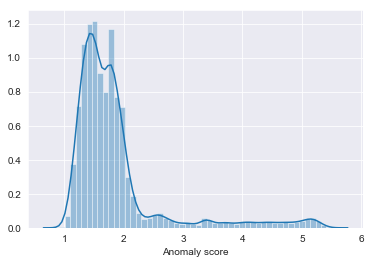

In [9]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

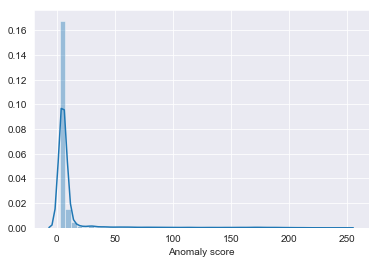

In [10]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [11]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

172.06

In [13]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/scotia_bank_data/SCOT-CAN-TOR-MW-U-370409_GigabitEthernet003_output.json', 'w') as output_file:
    json.dump(forest_dict, output_file)